In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as clr
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz
import random
import geopandas
import folium

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
missing_indices = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        missing_indices.append(index)
data = data.drop(missing_indices).reset_index(drop=True)
test_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")
train_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")
grad_effect_columns = train_data.loc[:, train_data.columns.str.startswith(('_y'))]
ordered_country_list = list(dict.fromkeys(train_data.iso))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]
data["block"] = [row.continent + "_" + str(row.year) for row in data.itertuples()]

/tmp/ipykernel_90337/436208037.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]


In [ ]:
# Add third degree incremental effects
for column in data:
    if "_yi" in column:
        new_column = column.replace("_yi", "_y3")
        data[new_column] = [getattr(row[1],column)**3 for row in data.iterrows()]

# Make dataset withholding random data points

In [ ]:
random.seed(1)
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

In [ ]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train_3rd_degree_grad_effects.csv")

In [ ]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train_3rd_degree_grad_effects.csv")

In [ ]:
pd.DataFrame(withheld_rows).to_csv("../data/burke/data/input/GrowthClimateDataset_test_3rd_degree_grad_effects.csv")

In [ ]:
data.to_csv("../data/burke/data/input/GrowthClimateDataset_full_encoded_iso_id_block_id_3rd_degree_grad_effects.csv")

In [ ]:
# Add back missing data
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
missing_rows = data.iloc[missing_indices]
data_mod_with_missing = data_mod._append(missing_rows, ignore_index=True)
pd.DataFrame(data_mod_with_missing).to_csv("../data/burke/data/input/GrowthClimateDataset_train_missing_data.csv")

# Bayesian Model

In [3]:
full_model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error.pkl')
withheld_model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')

In [73]:
az.summary(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
temp_gdp_coef,-0.640,0.221,-1.061,-0.225,0.016,0.011,191.0,491.0,1.02
temp_sq_gdp_coef,-0.454,0.090,-0.623,-0.284,0.004,0.003,606.0,1520.0,1.01
precip_gdp_coef,0.053,0.063,-0.066,0.172,0.002,0.001,1501.0,2235.0,1.00
precip_sq_gdp_coef,-0.042,0.022,-0.083,-0.001,0.000,0.000,1931.0,2377.0,1.00
gdp_intercept,0.386,0.423,-0.412,1.210,0.050,0.038,71.0,128.0,1.06


/tmp/ipykernel_6248/3226979871.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


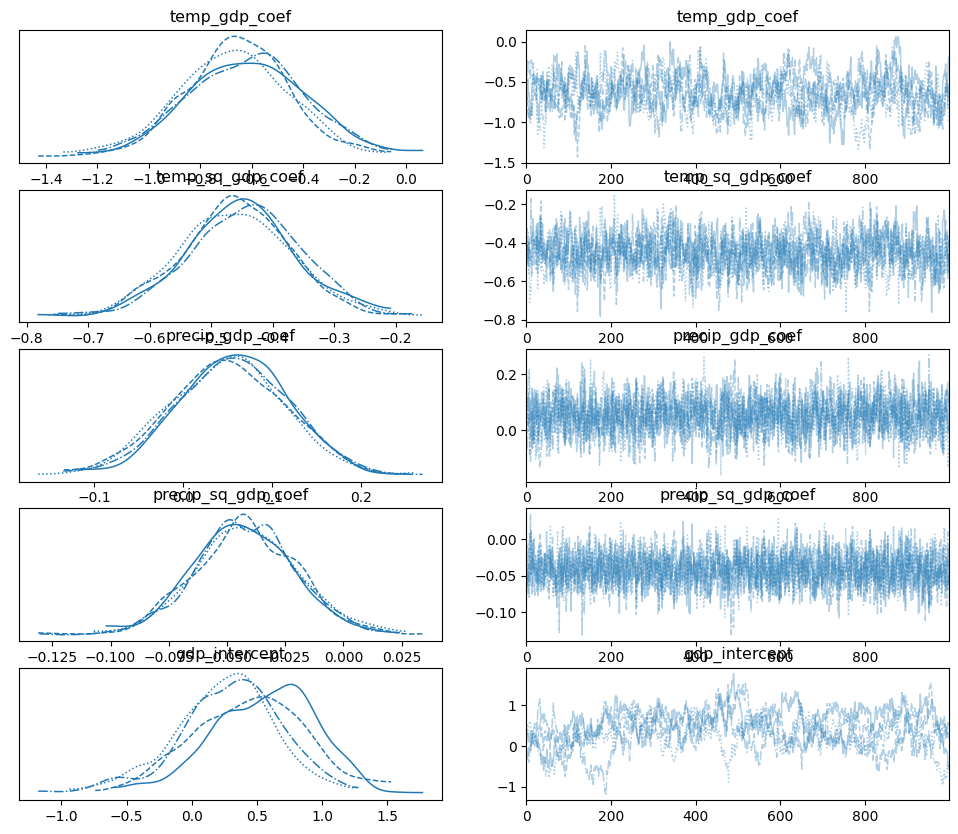

In [9]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef", "gdp_intercept"]).ravel()[0].figure
fig.show()

In [4]:
random.seed(1)
indices = random.sample(range(4000),1000)

bayes_coef1_withheld_scaled = np.array([sample for index, sample in enumerate(withheld_model["trace"].posterior.temp_gdp_coef.data.flatten()) if index in indices])
bayes_coef2_withheld_scaled = np.array([sample for index,sample in enumerate(withheld_model["trace"].posterior.temp_sq_gdp_coef.data.flatten()) if index in indices])
bayes_coef3_withheld_scaled = np.array([sample for index,sample in enumerate(withheld_model["trace"].posterior.precip_gdp_coef.data.flatten()) if index in indices])
bayes_coef4_withheld_scaled = np.array([sample for index,sample in enumerate(withheld_model["trace"].posterior.precip_sq_gdp_coef.data.flatten()) if index in indices])
bayes_intercept_withheld_scaled = np.array([sample for index,sample in enumerate(withheld_model["trace"].posterior.gdp_intercept.data.flatten()) if index in indices])
bayes_grad_coefs_withheld_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(withheld_model["trace"].posterior.grad_effect_coefs.data)) if index in indices])
bayes_country_coefs_withheld_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(withheld_model["trace"].posterior.country_coefs.data)) if index in indices])
bayes_year_coefs_withheld_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(withheld_model["trace"].posterior.year_coefs.data)) if index in indices])

bayes_coef1_full_scaled = np.array([sample for index, sample in enumerate(full_model["trace"].posterior.temp_gdp_coef.data.flatten()) if index in indices])
bayes_coef2_full_scaled = np.array([sample for index, sample in enumerate(full_model["trace"].posterior.temp_sq_gdp_coef.data.flatten()) if index in indices])
bayes_coef3_full_scaled = np.array([sample for index, sample in enumerate(full_model["trace"].posterior.precip_gdp_coef.data.flatten()) if index in indices])
bayes_coef4_full_scaled = np.array([sample for index, sample in enumerate(full_model["trace"].posterior.precip_sq_gdp_coef.data.flatten()) if index in indices])
bayes_intercept_full_scaled = np.array([sample for index, sample in enumerate(full_model["trace"].posterior.gdp_intercept.data.flatten()) if index in indices])
bayes_grad_coefs_full_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(full_model["trace"].posterior.grad_effect_coefs.data)) if index in indices])
bayes_country_coefs_full_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(full_model["trace"].posterior.country_coefs.data)) if index in indices])
bayes_year_coefs_full_scaled = np.transpose([sample for index,sample in enumerate(np.vstack(full_model["trace"].posterior.year_coefs.data)) if index in indices])

# unscale all model parameters
bayes_coef1_withheld = (bayes_coef1_withheld_scaled * np.std(train_data.growthWDI) / np.std(train_data.UDel_temp_popweight)) - (2 * ((bayes_coef2_withheld_scaled * np.mean(train_data.UDel_temp_popweight) * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_temp_popweight))))
bayes_coef2_withheld = (bayes_coef2_withheld_scaled * np.std(train_data.growthWDI) / np.square(np.std(train_data.UDel_temp_popweight)))
bayes_coef3_withheld = (bayes_coef3_withheld_scaled * np.std(train_data.growthWDI) / np.std(train_data.UDel_precip_popweight)) - (2 * ((bayes_coef4_withheld_scaled * np.mean(train_data.UDel_precip_popweight) * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))))
bayes_coef4_withheld = (bayes_coef4_withheld_scaled * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))

bayes_intercept_withheld = (bayes_intercept_withheld_scaled * np.std(train_data.growthWDI)) + np.mean(train_data.growthWDI) - ((bayes_coef1_withheld * np.mean(train_data.UDel_temp_popweight)) + (bayes_coef2_withheld * np.square(np.mean(train_data.UDel_temp_popweight))) + (bayes_coef3_withheld * np.mean(train_data.UDel_precip_popweight)) + (bayes_coef4_withheld * np.square(np.mean(train_data.UDel_precip_popweight))))
bayes_grad_coefs_withheld, bayes_country_coefs_withheld, bayes_year_coefs_withheld = [], [], []
for i in range(len(bayes_grad_coefs_withheld_scaled)):
    bayes_grad_coefs_withheld.append(bayes_grad_coefs_withheld_scaled[i] * np.std(train_data.growthWDI))
for i in range(len(bayes_country_coefs_withheld_scaled)):
    bayes_country_coefs_withheld.append(bayes_country_coefs_withheld_scaled[i] * np.std(train_data.growthWDI))
for i in range(len(bayes_year_coefs_withheld_scaled)):
    bayes_year_coefs_withheld.append(bayes_year_coefs_withheld_scaled[i] * np.std(train_data.growthWDI))

bayes_coef1_full = (bayes_coef1_full_scaled * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * ((bayes_coef2_full_scaled * np.mean(data.UDel_temp_popweight) * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
bayes_coef2_full = (bayes_coef2_full_scaled * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
bayes_coef3_full = (bayes_coef3_full_scaled * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight)) - (2 * ((bayes_coef4_full_scaled * np.mean(data.UDel_precip_popweight) * np.std(data.growthWDI)) / np.square(np.std(data.UDel_precip_popweight))))
bayes_coef4_full = (bayes_coef4_full_scaled * np.std(data.growthWDI) / np.square(np.std(data.UDel_precip_popweight)))

bayes_intercept_full = (bayes_intercept_full_scaled * np.std(data.growthWDI)) + np.mean(data.growthWDI) - ((bayes_coef1_full * np.mean(data.UDel_temp_popweight)) + (bayes_coef2_full * np.square(np.mean(data.UDel_temp_popweight))) + (bayes_coef3_full * np.mean(data.UDel_precip_popweight)) + (bayes_coef4_full * np.square(np.mean(data.UDel_precip_popweight))))
bayes_grad_coefs_full, bayes_country_coefs_full, bayes_year_coefs_full = [], [], []
for i in range(len(bayes_grad_coefs_full_scaled)):
    bayes_grad_coefs_full.append(bayes_grad_coefs_full_scaled[i] * np.std(data.growthWDI))
for i in range(len(bayes_country_coefs_full_scaled)):
    bayes_country_coefs_full.append(bayes_country_coefs_full_scaled[i] * np.std(data.growthWDI))
for i in range(len(bayes_year_coefs_full_scaled)):
    bayes_year_coefs_full.append(bayes_year_coefs_full_scaled[i] * np.std(data.growthWDI))

# Bayesian Model Vertex Confidence Bounds

In [5]:
numerator = [val for val in bayes_coef1_full]
denominator = [-2*(val) for val in bayes_coef2_full]
bayes_res = np.array(numerator) / np.array(denominator)
bayes_interval = np.quantile(sorted(bayes_res),[.05,.95])
print(np.mean(bayes_res), bayes_interval[0], bayes_interval[1])

13.667917470588938 10.941736577560091 16.30555124052961


# Bayesian Model Prediction Intervals

In [6]:
bayes_yhat = []
bayes_real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.sort_values(by="growthWDI").iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    bayes_real_y.append(row[1].growthWDI)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = bayes_country_coefs_withheld[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = bayes_year_coefs_withheld[year - min_year -1]
    predict_gdp = (
        temp*bayes_coef1_withheld + 
        np.square(temp)*bayes_coef2_withheld +
        precip*bayes_coef3_withheld +
        np.square(precip)*bayes_coef4_withheld +
        country_effect +
        year_effect +
        bayes_intercept_withheld
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* bayes_grad_coefs_withheld[i]
    predict_gdp += grad_effect
    bayes_yhat.append(sorted(predict_gdp))

In [7]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if bayes_real_y[index] >= interval[0] and bayes_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

0.6033333333333334
0.39666666666666667


# Block Bootstrap

In [ ]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_block.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_better_column_names.csv")

In [6]:
full_bootstrap = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_better_column_names.csv", header=1)
withheld_bootstrap = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_withheld_better_column_names.csv", header=1)

indices_to_drop = []
no_nan_cols = ["temp"]
for index, row in enumerate(withheld_bootstrap.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
withheld_bootstrap = withheld_bootstrap.drop(indices_to_drop)[:1000]

indices_to_drop = []
no_nan_cols = ["temp"]
for index, row in enumerate(full_bootstrap.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
full_bootstrap = full_bootstrap.drop(indices_to_drop)[:1000]

# Block Bootstrap Vertex Confidence Bounds

In [7]:
numerator = [val for val in full_bootstrap["temp"] if not np.isnan(val)]
denominator = [-2*(val) for val in full_bootstrap["c.temp#c.temp"] if not np.isnan(val)]
boot_res = np.array(numerator) / np.array(denominator)
boot_interval = np.quantile(boot_res,[.05,.95])
print(np.mean(boot_res), boot_interval[0], boot_interval[1])

13.350232507049979 10.002080496232905 17.289247964473756


# Block Bootstrap Prediction Intervals

In [10]:
boot_yhat = []
boot_real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.sort_values(by="growthWDI").iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    boot_real_y.append(row[1].growthWDI)
    predict_gdp = (
        temp*withheld_bootstrap.temp + 
        np.square(temp)*withheld_bootstrap["c.temp#c.temp"] +
        precip*withheld_bootstrap.udel_precip_popweight +
        np.square(precip)*withheld_bootstrap.udel_precip_popweight_2 +
        withheld_bootstrap[country] +
        withheld_bootstrap[str(year)] +
        withheld_bootstrap["intercept"]
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* withheld_bootstrap[effect.lower()]
    predict_gdp += grad_effect
    boot_yhat.append(sorted(predict_gdp))

In [11]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if boot_real_y[index] >= interval[0] and boot_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

0.57
0.43


# Delta Method

In [8]:
# Simulation from Stata 
delta_vertex = 13.055431
delta_sd = 1.7304575
delta_sim_res = np.random.normal(delta_vertex, delta_sd, 1000)
delta_interval = np.quantile(delta_sim_res,[.05,.95])
print(np.mean(delta_sim_res), delta_interval[0], delta_interval[1])

13.019865125335425 10.100477662405881 15.999449181561785


In [15]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
delta_real_y = []

delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_outsample_withheld.csv")
# delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_insample.csv")
for row in enumerate(delta_yhat.sort_values(by="growthwdi").itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    delta_real_y.append(row[1].growthwdi)
    if lower <= delta_real_y[-1] and upper >= delta_real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

0.6033333333333334
0.39666666666666667


# Figures

In [9]:
colors = {"Bayes":"orange","Bootstrap":"green","Delta":"purple"}

# Make Figure 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


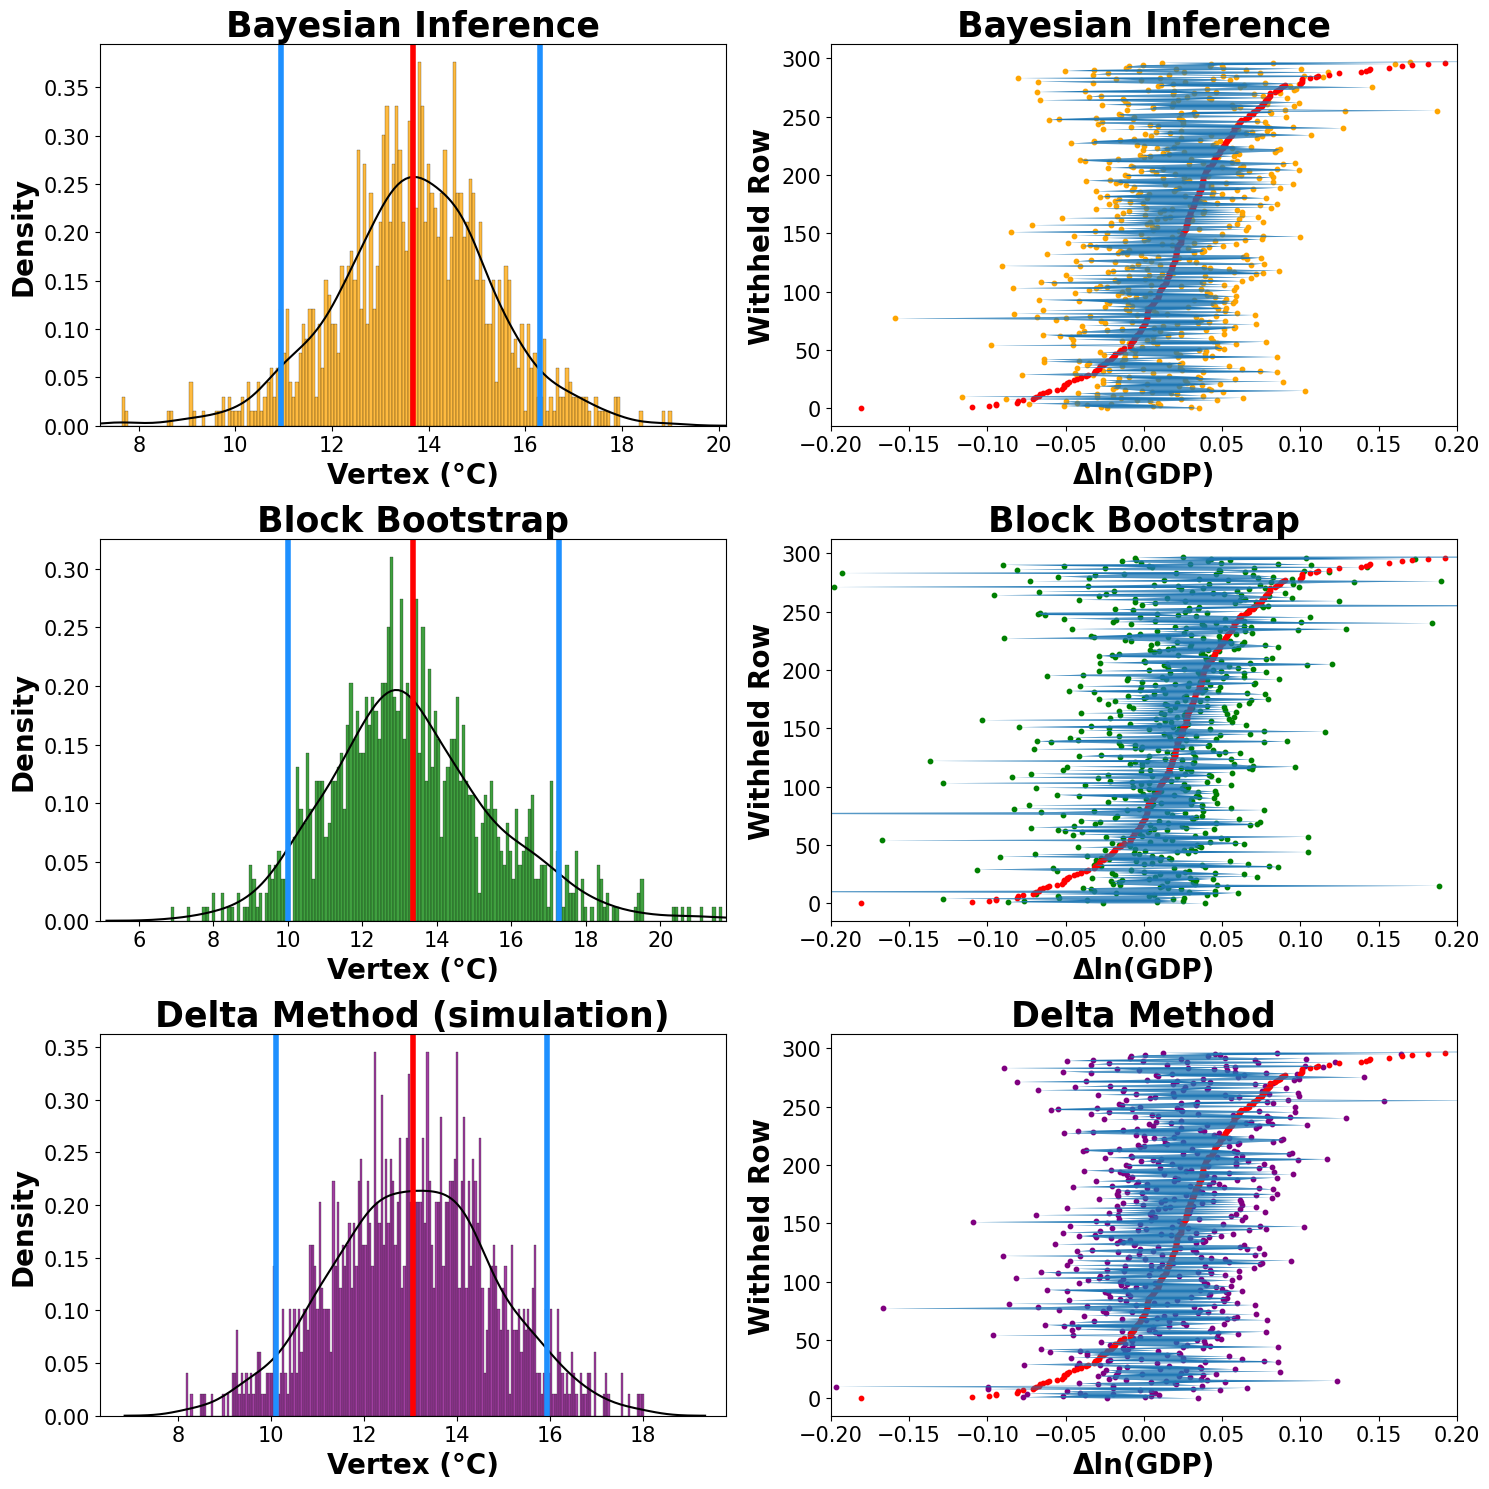

In [16]:
def make_hist_plot(axis, data, interval, color, labels):
    x = np.linspace(np.mean(data) - 3*np.std(data), np.mean(data) + 3*np.std(data), 100)
    sns.histplot(data,bins=200,color=color,stat="density", ax=axis)
    sns.kdeplot(data, ax=axis, color="black")
    axis.set_xlim(min(x)-1.5, max(x)+1.5)
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    axis.axvline(x = np.mean(data), color = 'r', lw = 4, label = labels[0])
    axis.axvline(x = interval[0], color = 'dodgerblue', lw = 4, label = labels[1])
    axis.axvline(x = interval[1], color = 'dodgerblue', lw = 4, label = labels[2])
    axis.set_xlabel("Vertex (°C)", weight="bold")
    axis.set_ylabel("Probability Density", weight="bold")
    axis.set_title(labels[4], weight="bold")
    axis.title.set_size(25)

def make_pred_int_plots(axis, lowers, uppers, real_y, color, label):
    axis.scatter(lowers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(uppers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(real_y, list(range(len(lowers))), color="red", s=10)
    last_line = None
    for index in range(len(lowers)):
        if last_line != None:
            axis.add_patch(
                patches.Polygon(
                    xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
                )
            )
        last_line = [lowers[index],uppers[index]]
    axis.set_xlabel("Δln(GDP)", weight="bold")
    axis.set_ylabel("Withheld Row #", weight="bold")
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    axis.set_title(label, weight="bold")
    axis.title.set_size(25)
    axis.set_xlim(-.2, .2)

fig, axes = plt.subplots(3,2, figsize=(15,15))

make_hist_plot(axes[0][0], bayes_res, bayes_interval, colors["Bayes"],
    labels=[
    'Bayesian Inference Vertex Mean', 'Bayesian Inference Vertex Lower Bound',
    'Bayesian Inference Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Bayesian Inference'
])
make_hist_plot(axes[1][0], boot_res, boot_interval, colors["Bootstrap"],
    labels=[
    'Block Bootstrap Vertex Mean', 'Block Bootstrap Vertex Lower Bound',
    'Block Bootstrap Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Block Bootstrap'
])
make_hist_plot(axes[2][0], delta_sim_res, delta_interval, colors["Delta"],
    labels=[
    'Delta Method Vertex Mean', 'Delta Method Vertex Lower Bound',
    'Delta Method Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Delta Method (simulation)'
])

make_pred_int_plots(axes[0][1], bayes_lowers[2:300], bayes_uppers[2:300], bayes_real_y[2:300], colors["Bayes"], "Bayesian Inference")
make_pred_int_plots(axes[1][1], boot_lowers[2:300], boot_uppers[2:300], boot_real_y[2:300], colors["Bootstrap"], "Block Bootstrap")
make_pred_int_plots(axes[2][1], delta_lowers[2:300], delta_uppers[2:300], delta_real_y[2:300], colors["Delta"], "Delta Method")

fig.tight_layout()

# plt.show()
# plt.savefig("../figures/fig1_working.png", bbox_inches='tight')
plt.savefig("../figures/fig1_no_labels.eps", bbox_inches='tight', format="eps", dpi=1000)

# Estimate affected countries based on CMIP6

In [33]:
temp_projections = pd.read_csv(
    "../data/global_data/cmip6-x0.25_timeseries_tas_timeseries-tas-annual-mean_annual_2015-2100_median_ssp119_ensemble_all_mean - all.csv"
)
countries_at_risk = {"country":[],"bayes":[],"bootstrap":[],"delta":[],"point_est":[]}

bayes_countries = set()
boot_countries = set()
delta_countries = set()
point_est_countries = set()

for row in temp_projections.iterrows():
    row = row[1]
    country = row.code
    if "." not in country:
        temp_curr = row["2024-07"]
        for year in range(2025,2101):
            temp_fut = row[f"{year}-07"]
            if temp_fut < bayes_interval[1] and temp_fut > bayes_interval[0]:
                bayes_countries.add(country)
            if temp_fut < boot_interval[1] and temp_fut > boot_interval[0]:
                boot_countries.add(country)
            if temp_fut < delta_interval[1] and temp_fut > delta_interval[0]:
                delta_countries.add(country)
            if temp_curr < delta_vertex and temp_fut > delta_vertex:
                point_est_countries.add(country)
            
for country in set(temp_projections.code):
    countries_at_risk["country"].append(country)
    if country in bayes_countries:
        countries_at_risk["bayes"].append(1)
    else:
        countries_at_risk["bayes"].append(0)
    if country in boot_countries:
        countries_at_risk["bootstrap"].append(1)
    else:
        countries_at_risk["bootstrap"].append(0)
    if country in delta_countries:
        countries_at_risk["delta"].append(1)
    else:
        countries_at_risk["delta"].append(0)
    if country in point_est_countries:
        countries_at_risk["point_est"].append(1)
    else:
        countries_at_risk["point_est"].append(0)

countries_at_risk_df = pd.DataFrame.from_dict(countries_at_risk)

# Build map based on CMIP6 predictions

/tmp/ipykernel_90337/1761328494.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


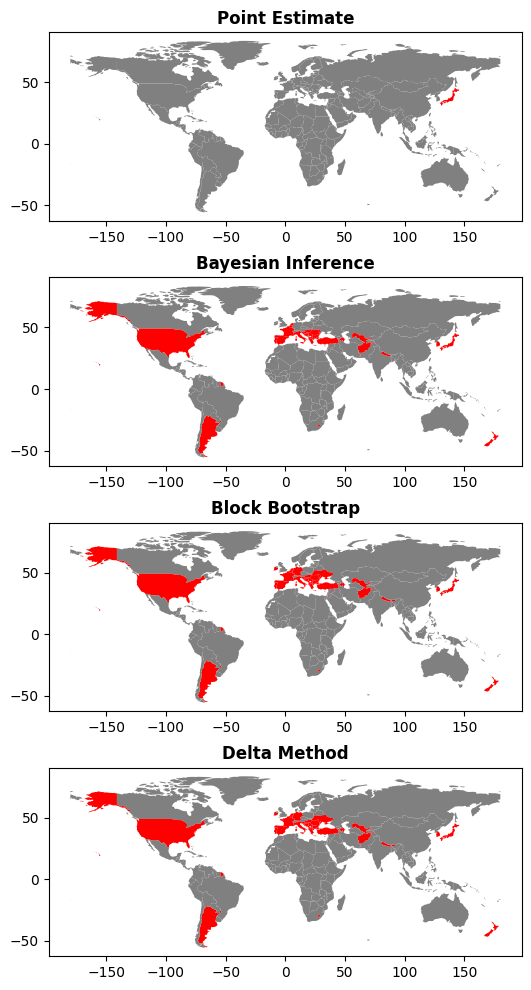

In [34]:
country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    countries_at_risk_df,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)

fig, axes = plt.subplots(4,1, figsize=(12,12))
fig.subplots_adjust(hspace=.3, wspace=0.0)
color_list = ["gray","red"]
custom_cmap = clr.ListedColormap(color_list)
axis_map = {0:axes[0], 1:axes[1], 2:axes[2], 3:axes[3]} 
title_map = {"point_est":"Point Estimate","bayes":"Bayesian Inference","bootstrap":"Block Bootstrap","delta":"Delta Method"}

for index, technique in enumerate(["point_est","bayes","bootstrap","delta"]):
    country_geopandas.plot(column=technique, cmap=custom_cmap, ax=axis_map[index])
    axis_map[index].set_title(title_map[technique], weight="bold")
plt.savefig("../figures/fig2.eps", bbox_inches='tight', format="eps", dpi=1000)

# Barplots of parameter uncertainty

In [18]:
def normalize_coefficient(x_data, y_data, orig_coef, squared_term=True, orig_coef2=None):
    if not squared_term:
        assert len(orig_coef2) == len(orig_coef)
        return (
            (np.std(x_data) / np.std(y_data)) * 
            (orig_coef + 
             (2*
              (
                  (orig_coef2 * np.mean(x_data) * np.std(y_data)) /
                  np.square(np.std(x_data))
              )
             )
            )
        )
    else:
        return orig_coef * np.square(np.std(x_data)) / np.std(y_data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


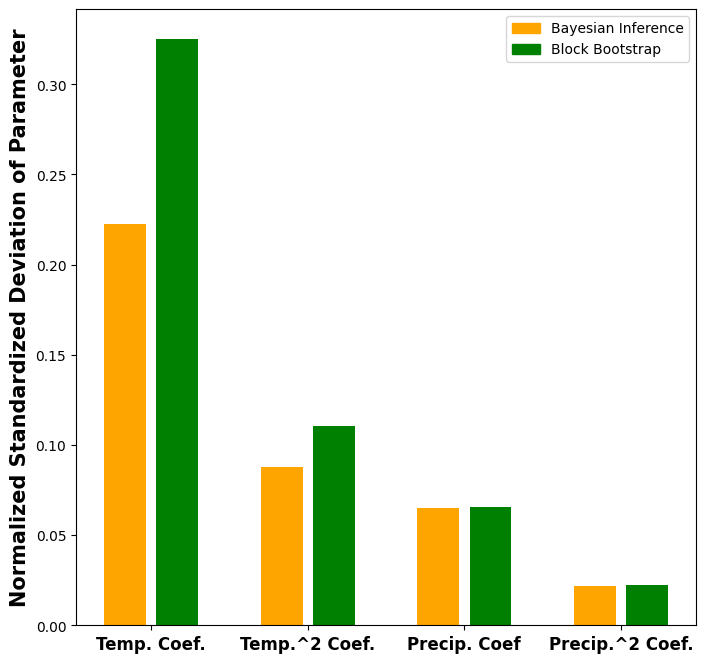

In [19]:
bayes_coef1_full_rescaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, bayes_coef1_full, False, bayes_coef2_full_scaled)
bayes_coef2_full_rescaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, bayes_coef2_full)
bayes_coef3_full_rescaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, bayes_coef3_full, False, bayes_coef4_full_scaled)
bayes_coef4_full_rescaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, bayes_coef4_full)

boot_coef2_full_scaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, full_bootstrap["c.temp#c.temp"])
boot_coef1_full_scaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, full_bootstrap.temp, False, boot_coef2_full_scaled)
boot_coef4_full_scaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, full_bootstrap.udel_precip_popweight_2)
boot_coef3_full_scaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, full_bootstrap.udel_precip_popweight, False, boot_coef4_full_scaled)

# Parameter variance from covariance matrix
# delta_coef1_sim = np.random.normal(.01271835, np.sqrt(.00001055), 1000)
# delta_coef2_sim = np.random.normal(-.00048709, np.sqrt(1.060e-08), 1000)
# delta_coef3_sim = np.random.normal(.00001445, np.sqrt(1.050e-10), 1000)
# delta_coef4_sim = np.random.normal(-4.746e-09, np.sqrt(6.247e-18), 1000)

# delta_coef2_scaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, delta_coef2_sim)
# delta_coef1_scaled = normalize_coefficient(data.UDel_temp_popweight, data.growthWDI, delta_coef1_sim, False, delta_coef2_scaled)
# delta_coef4_scaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, delta_coef4_sim)
# delta_coef3_scaled = normalize_coefficient(data.UDel_precip_popweight, data.growthWDI, delta_coef3_sim, False, delta_coef4_scaled)

fig, axis = plt.subplots(1,1, figsize=(8,8))

plt_xvals = [1,2,4,5,7,8,10,11]
axis.bar(
    plt_xvals,
    [
        np.std(bayes_coef1_full_rescaled),
        np.std(boot_coef1_full_scaled),
        # np.std(delta_coef1_scaled),
        np.std(bayes_coef2_full_rescaled),
        np.std(boot_coef2_full_scaled),
        # np.std(delta_coef2_scaled),
        np.std(bayes_coef3_full_rescaled),
        np.std(boot_coef3_full_scaled),
        # np.std(delta_coef3_scaled),
        np.std(bayes_coef4_full_rescaled),
        np.std(boot_coef4_full_scaled),
        # np.std(delta_coef4_scaled)
    ],
    color=[colors["Bayes"],colors["Bootstrap"],colors["Bayes"],colors["Bootstrap"],colors["Bayes"],colors["Bootstrap"],colors["Bayes"],colors["Bootstrap"]]
)
barplot_legend = {"Bayesian Inference":"orange","Block Bootstrap":"green"}
labels = list(barplot_legend.keys())
handles = [plt.Rectangle((0,0),1,1, color=barplot_legend[label]) for label in labels]
axis.legend(handles, labels)
axis.set_xticks([1.5,4.5,7.5,10.5],["Temp. Coef.","Temp.^2 Coef.","Precip. Coef","Precip.^2 Coef."],weight="bold",size=12)
axis.set_ylabel("Normalized Standardized Deviation of Parameter", weight="bold")
axis.yaxis.label.set_size(15)
plt.savefig("../figures/fig3_part1_no_labels.eps", format="eps", dpi=1000)

# Histogram of fixed effect uncertainty

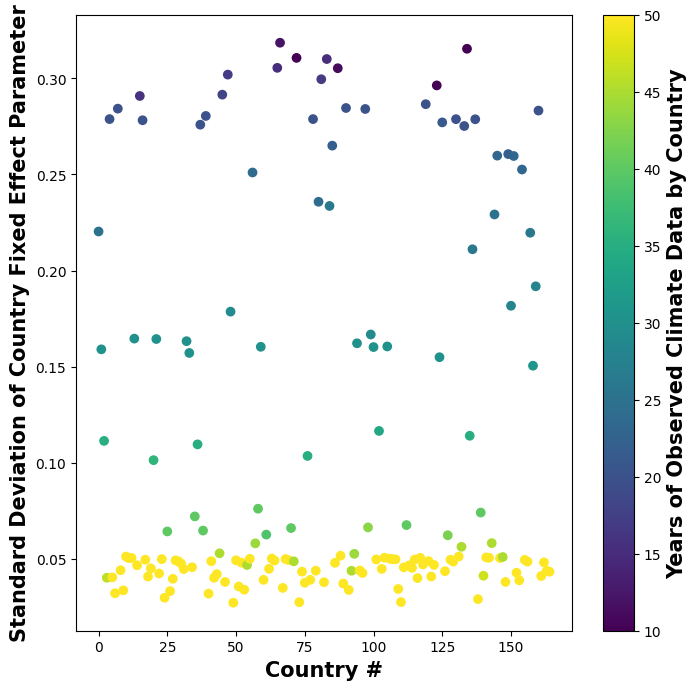

In [20]:
country_coef_std = []
country_temp_std = []
for index, country in enumerate(ordered_country_list):
    if index == 0:
        # country_coef_std.append(np.std(bayes_intercept_full))
        continue
    else:
        country_coef_std.append(np.std(bayes_country_coefs_full[index-1] + bayes_intercept_full))
        country_temp_std.append(len(data.loc[(data.iso == country)]["UDel_temp_popweight"]))
fig, axis = plt.subplots(1,1, figsize=(8,8))
points = axis.scatter(range(len(country_coef_std)), country_coef_std, c=country_temp_std)
cbar = fig.colorbar(points)
cbar.set_label("Years of Observed Climate Data by Country", weight="bold", size=15)
axis.set_ylabel("Standard Deviation of Country Fixed Effect Parameter", weight="bold")
axis.set_xlabel("Country #", weight="bold")
axis.xaxis.label.set_size(15)
axis.yaxis.label.set_size(15)
plt.savefig("../figures/fig3_part2_no_labels.eps", format="eps", dpi=1000)